## **Data Blocks Tutorial**

Wanted to understand better how datablocks work, including the multi-level APIs. Following mostly these tutorials [1](https://docs.fast.ai/tutorial.imagenette.html) and [2](https://docs.fast.ai/tutorial.datablock.html).

In first iteration I came 50th percentile.

Key Learning points:
1. Datablocks are a collection of all the things needed to create a dataloader
2. Don't call the get_items and get_y functions when defining the datablock, just give their names!
3. 

In [1]:
!chmod +x setup_comp.sh
!./setup_comp.sh

In [2]:
!pip install -Uq kaggle fastai nbdev

In [3]:
from pathlib import Path
import zipfile
import kaggle
import pandas as pd

from fastai.data.all import *
from fastai.vision.all import *

In [4]:
path = Path('sign-language-image-classification')
kaggle.api.competition_download_cli(str(path))
zipfile.ZipFile(f'{path}.zip').extractall(path)

sign-language-image-classification.zip: Skipping, found more recently modified local copy (use --force to force download)


1. Get the items. Images can be built from filenames

**NB, the key is not to call the method when it is passed to the Datablock, simply pass the method instead. So `get_image_files` not `get_image_files(path)`!!!**

The only data I have labels for is in the train folder! So make sure that is the one thats used.

In [37]:
def get_items(path):
    return get_image_files(Path('sign-language-image-classification/images/images/train'))

In [38]:
fnames = get_items(path)

In [39]:
dblock = DataBlock(get_items = get_items)


In [40]:
dsets = dblock.datasets(Path('sign-language-image-classification/images/images/train'))
dsets.train[0]

(Path('sign-language-image-classification/images/images/train/03449a15fea49123a515635bdfc23857.jpg'),
 Path('sign-language-image-classification/images/images/train/03449a15fea49123a515635bdfc23857.jpg'))

2. `get_y()`, define the function that takes the 'item' (in this case the path to each file) and converts it to a label.

In [41]:
def label_func(fname):
    label_list = pd.read_csv(path/'train.csv', index_col=0)
    return label_list.loc[fname.name,'label']

In [42]:
dblock = DataBlock(get_items = get_items,
                   get_y = label_func)

In [43]:
dsets = dblock.datasets(Path('sign-language-image-classification/images/images/train'))
dsets.train[0]

(Path('sign-language-image-classification/images/images/train/21cc026ff65b8fefa7b07afb8a169552.jpg'),
 17)

3. define the custom splitter and label the type of blocks!

I did a custom splitter following this guidance, but then realised I didnt need to! Still, very useful (alongside chatGPT!)

Input Acceptance: Your custom splitter function should accept the entire dataset (items) as input. This dataset will be whatever is returned by your get_items call.

Output Format: It must return two lists (or any indexable collection) of integers: the first for training indices and the second for validation indices. These indices correspond to the positions of your items in the dataset.

Non-Overlap: Ensure that the training and validation sets do not overlap; each item should only be in one set.

Coverage: Ideally, every item in your dataset should be used, either in the training or validation set, unless intentionally excluding some items.

Reproducibility: If your model training requires reproducibility, your splitter should incorporate a way to seed any random operations to ensure that the split is the same across runs, if needed.


In [58]:
dblock = DataBlock( blocks    = (ImageBlock, CategoryBlock),
                    get_items = get_image_files,
                    get_y = label_func,
                    splitter = RandomSplitter(),
                    item_tfms = Resize(224,method='squish'))
                   

In [59]:
dsets = dblock.datasets(Path('sign-language-image-classification/images/images/train'))
dsets.train[0]

(PILImage mode=RGB size=449x609, TensorCategory(18))

In [60]:
dsets.vocab

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]

**Train the model**

In [61]:
dls = dblock.dataloaders(Path('sign-language-image-classification/images/images/train'))

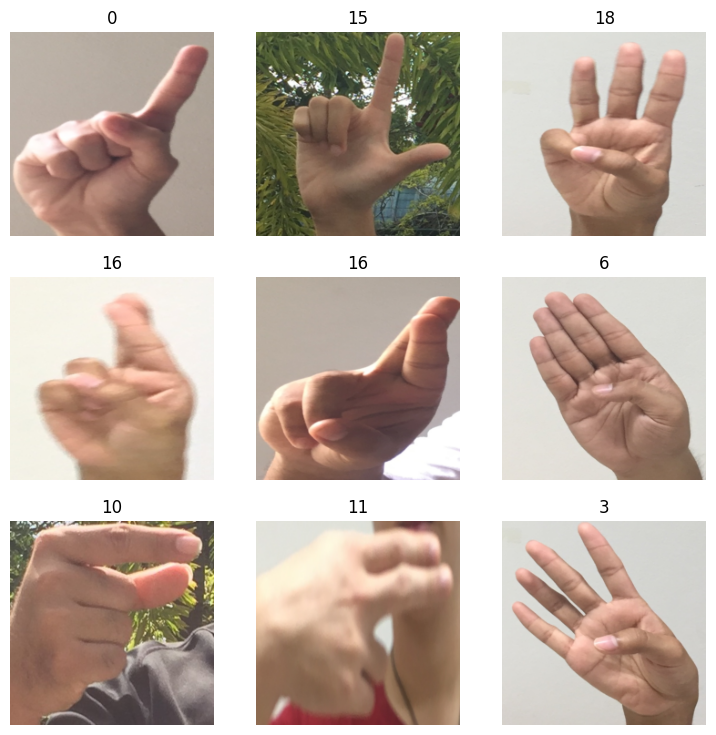

In [62]:
dls.show_batch()

In [63]:
learn = vision_learner(dls, resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

In [64]:
learn.fine_tune(4)

epoch,train_loss,valid_loss,accuracy,time
0,3.000507,0.848058,0.702500,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.750238,0.281340,0.902500,00:17
1,0.386816,0.119982,0.965000,00:16
2,0.220081,0.082478,0.980000,00:17
3,0.135301,0.077424,0.975000,00:17


In [81]:
test_items = get_image_files(Path('sign-language-image-classification/images/images/test'))
test_dl = learn.dls.test_dl(test_items)
preds, _ = learn.get_preds(dl=test_dl)

# this returns the likelyhood of each class
# we want the index of the highest likelyhood
# preds returns a torch.Size([1504, 20]), i want a final tensor of Size([1504]) 

labels = [dls.vocab[i] for i in preds.argmax(dim=-1)]

In [94]:
submission = pd.Series(test_items).apply(lambda x: x.name)
submission = pd.DataFrame(submission)
submission['predict'] = labels
submission.rename(columns={0: 'id'}, inplace=True)


In [96]:
submission.to_csv('submit.csv', index=False)

In [82]:
submission = pd.read_csv(path/'submit.csv')

submit!

In [98]:
!kaggle competitions submit -c sign-language-image-classification -f submit.csv -m "api"

100%|███████████████████████████████████████| 58.0k/58.0k [00:00<00:00, 116kB/s]
Successfully submitted to Sign Language Image Classification